In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# TCGA

#### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
# read in other already computed files
# from running analysis.main() 
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)


In [17]:
# read in train and test samples
train_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/train_samples.txt"
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
# read in train and test samples
test_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/test_samples.txt"
with open(test_samples_fn, "r") as f:
    testing_samples = f.read().splitlines()
# read in mi
mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/tcga_training_mi.parquet')
mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

#### Mut clock

In [14]:
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output"
    )

In [27]:
mut_clock.driver(
    do = 'train', num_correl_sites = 1000, max_meqtl_sites = 1000,
    nearby_window_size = 5000, cpg_ids = ['cg02682520'], 
    aggregate = "Both", binarize = False
    )

Finished 0.0% of CpGs


In [39]:
train_pred_methyl = mut_clock.predict_all_cpgs(
    cpg_ids = mi_df.head(100).index.to_list(), test_samples = training_samples,
    model_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/tcga_trained_models", aggregate = 'Both', binarize = False
    )
# get pairwise correlations between predicted and actual methylation
train_corrs = train_pred_methyl[mi_df.head(100).index.to_list()].corrwith(all_methyl_age_df_t.loc[training_samples, mi_df.head(100).index.to_list()], axis=0, method='pearson')
# get pairwise MAEs between predicted and actual methylation
train_maes = np.abs(train_pred_methyl[mi_df.head(100).index.to_list()] - all_methyl_age_df_t.loc[training_samples, mi_df.head(100).index.to_list()]).mean(axis=0)

In [48]:
train_methyl = all_methyl_age_df_t.loc[training_samples, mi_df.head(100).index.to_list()]
cpg_priority_df = mut_clock.choose_clock_cpgs(
    train_pred_methyl, train_methyl, mi_df
    )

<AxesSubplot:xlabel='mae', ylabel='corr'>

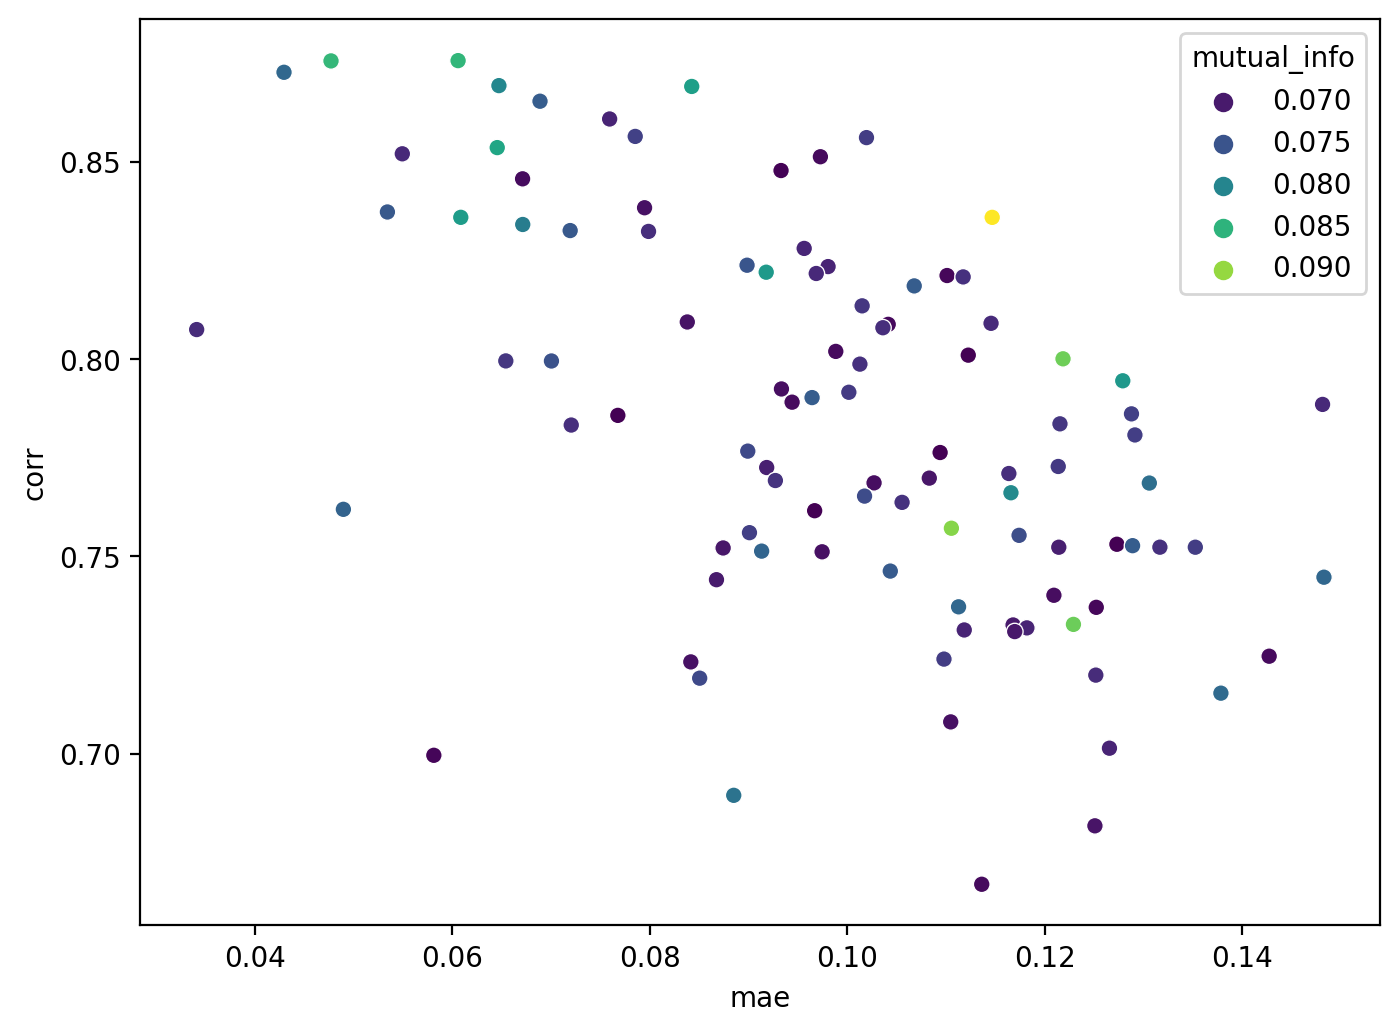

In [51]:
fig, axes = plt.subplots(figsize=(8, 6), dpi=100)
sns.scatterplot(data=cpg_priority_df, x='mae', y='corr', hue='mutual_info', palette='viridis', ax = axes)

#### Save all features

In [179]:
# read in training MI
mi_df = pd.read_parquet(os.path.join(out_dir, "training_actual_methyl_mi.parquet"))
# get index of n largest values
largest_mi = mi_df.nlargest(100000, columns=["mutual_info"]).index


In [191]:
mut_clock.save_all_predictor_groups(
    num_correl_sites = 5000, max_meqtl_sites = 5000, nearby_window_size = 10000, 
    out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/5000correl_5000meqtl_10000window_80percTrain",
    cpg_ids = mi_df.nlargest(1, columns=["mutual_info"]).index, train_samples = training_samples
    )

Finished 0.0% of CpGs


In [33]:
res_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/501_1501_cpg_predictions_df.parquet")
res_df2 = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/all_cpg_predictions_df.parquet")
res_df = pd.concat([res_df, res_df2], axis = 0)

In [35]:
res_df['mean_r2'] = res_df['r2'].apply(lambda x: np.mean(x))
res_df['mean_mae'] = res_df['mae'].apply(lambda x: np.mean(x))
res_df['base_mean_r2'] = res_df['base_r2'].apply(lambda x: np.mean(x))
res_df['base_mean_mae'] = res_df['base_mae'].apply(lambda x: np.mean(x))
res_df['diff_r2'] = res_df['mean_r2'] - res_df['base_mean_r2']
res_df['diff_mae'] = res_df['mean_mae'] - res_df['base_mean_mae']

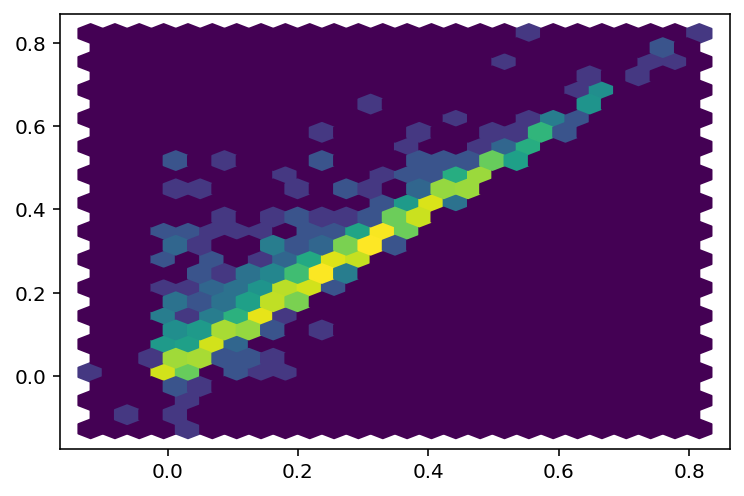

In [39]:
plt.hexbin(res_df['base_mean_r2'], res_df['mean_r2'], bins = 'log', gridsize = 25)

#### One feature matrix to rule them all

In [24]:
# create a dict of Nkb windows of each chromosome
chr_windows = {}
for chr_num in range(1, 23):
    for start in range(0, 249250621, 10000):
        chr_windows[str(chr_num) + ':' + str(start)] = []
        

In [ ]:
all_mut_w_age_piv = mut_clock.all_mut_w_age_df.pivot_table(index = ['mut_loc'] , columns = ['case_submitter_id'], values = ['DNA_VAF'], fill_value=0)
# make all_mut_w_age_piv not a multiindex
all_mut_w_age_piv.columns = all_mut_w_age_piv.columns.droplevel(0)

In [ ]:
window_size = 10000
for col in all_mut_w_age_piv.columns:
    chrom, start = col.split(':')
    start = int(start)
    # round down start value to nearest multiple of 10000
    start = round(int(start/window_size))*window_size
    # add to the appropriate window
    chr_windows[chrom + ':' + str(start)] += all_mut_w_age_piv[col].values.tolist()
    

<AxesSubplot:>

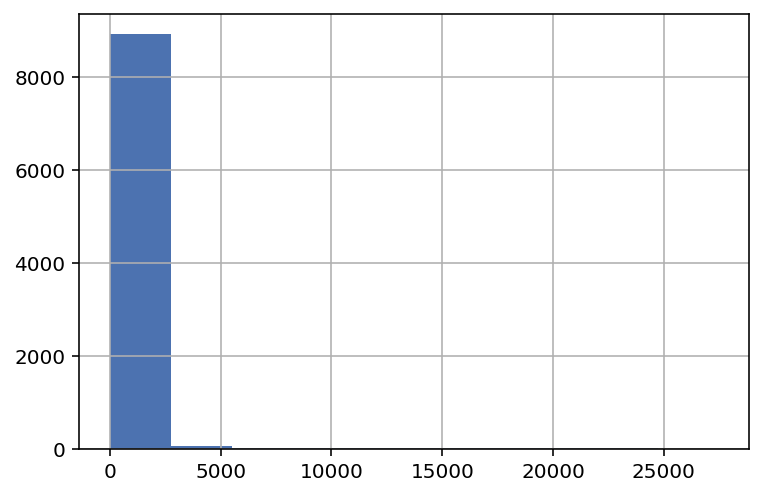

In [24]:
all_mut_df['sample'].value_counts().hist()

In [22]:
len(chr_windows)

24926

#### Performance

In [ ]:
cpg_ids = mut_clock.all_methyl_age_df_t.columns[1000:1002]
train_samples_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/train_samples.txt"
with open(train_samples_fn, "r") as f:
    training_samples = f.read().splitlines()
clock_perf_df = mut_clock.train_all_predictors(num_correl_sites = 1000, max_meqtl_sites = 1000,
        nearby_window_size = 5000, cpg_ids = cpg_ids, train_samples = training_samples, evaluate = True
        )
clock_perf_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_122622/eval_results/501_1501_cpg_predictions_df.parquet")

In [128]:
clock_perf_df = result_df
#clock_perf_df.set_index("cpg_id", inplace=True)
clock_perf_df['mean_mae'] = clock_perf_df['mae'].apply(lambda x: np.mean(x))
clock_perf_df['mean_r2'] = clock_perf_df['r2'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_mae'] = clock_perf_df['base_mae'].apply(lambda x: np.mean(x))
clock_perf_df['base_mean_r2'] = clock_perf_df['base_r2'].apply(lambda x: np.mean(x))
clock_perf_df['num_features'] = clock_perf_df['feature_names'].apply(lambda x: len(x[0]))
clock_perf_df['base_num_features'] = clock_perf_df['base_feature_names'].apply(lambda x: len(x[0]))

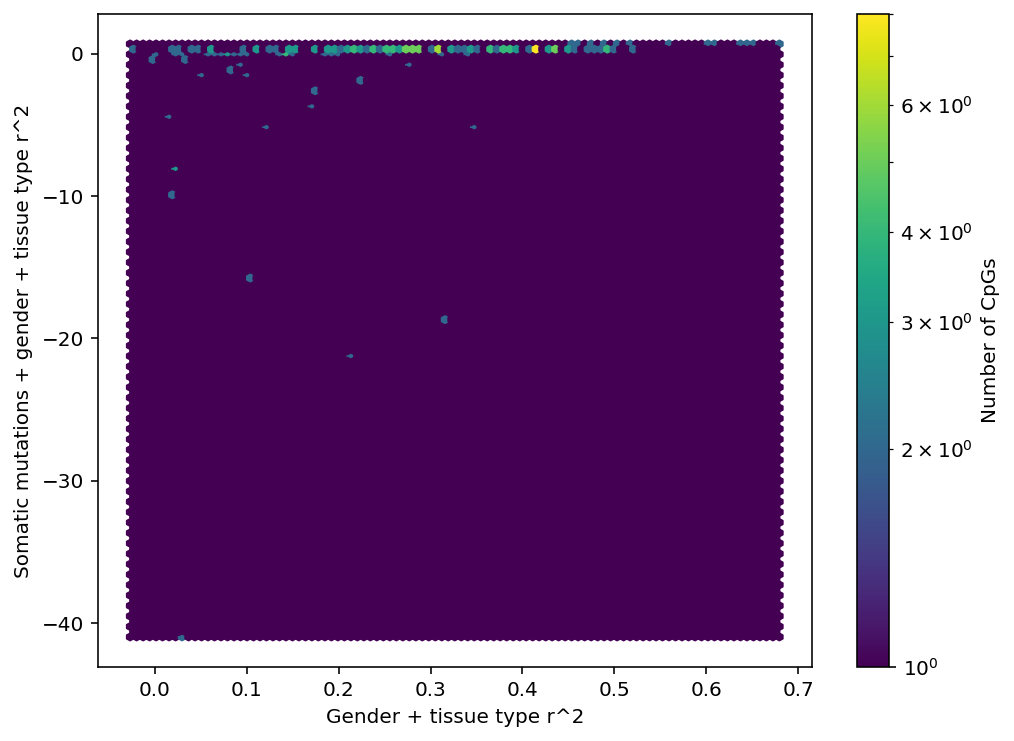

In [35]:
plt.rcParams["figure.figsize"] = (8,6)

plt.hexbin(clock_perf_df['base_mean_r2'], clock_perf_df['mean_r2'], bins='log')
plt.ylabel("Somatic mutations + gender + tissue type r^2")
plt.xlabel("Gender + tissue type r^2")
plt.colorbar( label = "Number of CpGs")
# set x and y range to 0,1


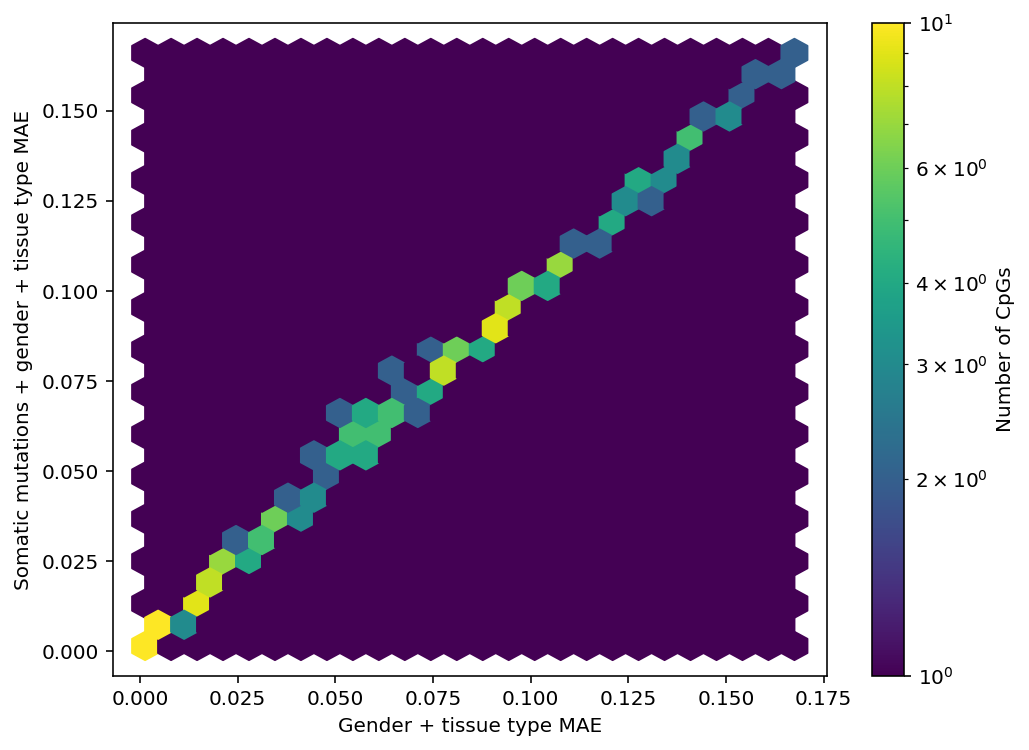

In [36]:
plt.rcParams["figure.figsize"] = (8,6)

plt.hexbin(clock_perf_df['base_mean_mae'], clock_perf_df['mean_mae'], gridsize=25, bins='log')
plt.ylabel("Somatic mutations + gender + tissue type MAE")
plt.xlabel("Gender + tissue type MAE")
plt.colorbar( label = "Number of CpGs")

#### Define train and test

In [141]:
from sklearn.model_selection import train_test_split
# balance dataset between training and testing
X_train, X_test = train_test_split(all_methyl_age_df_t, random_state=0, test_size=0.2, train_size=0.8, stratify=all_methyl_age_df_t['dataset'])

<AxesSubplot:>

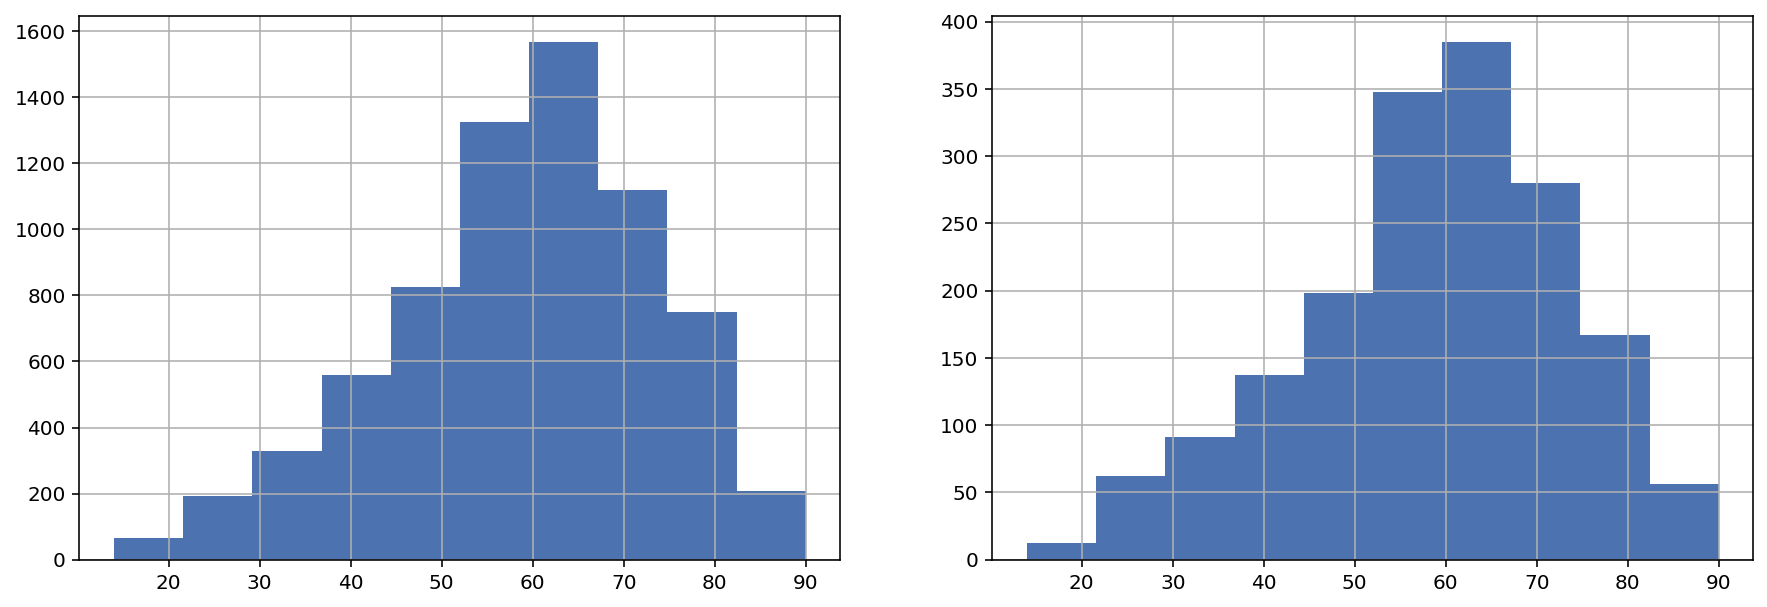

In [150]:
# this also results in a fairly balanced age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X_train['age_at_index'].hist(ax=axes[0])
X_test['age_at_index'].hist(ax = axes[1])


#### Mutual information calc

In [36]:
mut_clock.all_methyl_age_df_t.shape

(8782, 273239)

In [52]:
train_df = mut_clock.all_methyl_age_df_t.loc[training_samples, :]
ages = train_df['age_at_index']
train_df = train_df.iloc[:, 1:-36]
train_df.drop(columns=['age_at_index'], inplace=True)


In [61]:
mi = mut_clock.mutual_info(
    X = train_df,
    covariate = ages
    )

In [62]:
mi_df = mi.to_frame()
mi_df.columns = ['mutual_info']
mi_df.sort_values(by=['mutual_info'], ascending=False, inplace=True)
mi_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/tcga_training_mi.parquet')

#### Feature information

In [10]:
mi_df = pd.read_parquet(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423', "training_actual_methyl_mi.parquet"))
mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)


In [ ]:
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/5000correl_5000meqtl_5000window_80percTrain"
feat_mi_df1 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 5000,
        max_meqtl_sites = 5000, nearby_window_size = 5000, aggregate = True,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/10000correl_10000meqtl_10000window_80percTrain"
feat_mi_df2 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 10000,
        max_meqtl_sites = 10000, nearby_window_size = 10000, aggregate = True,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/1000correl_1000meqtl_1000window_80percTrain"
feat_mi_df3 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 1000, aggregate = True,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )

/tmp/ipykernel_1696352/1284223556.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = feat_mi_df2.iloc[:6, :].T.hist(ax = axes)


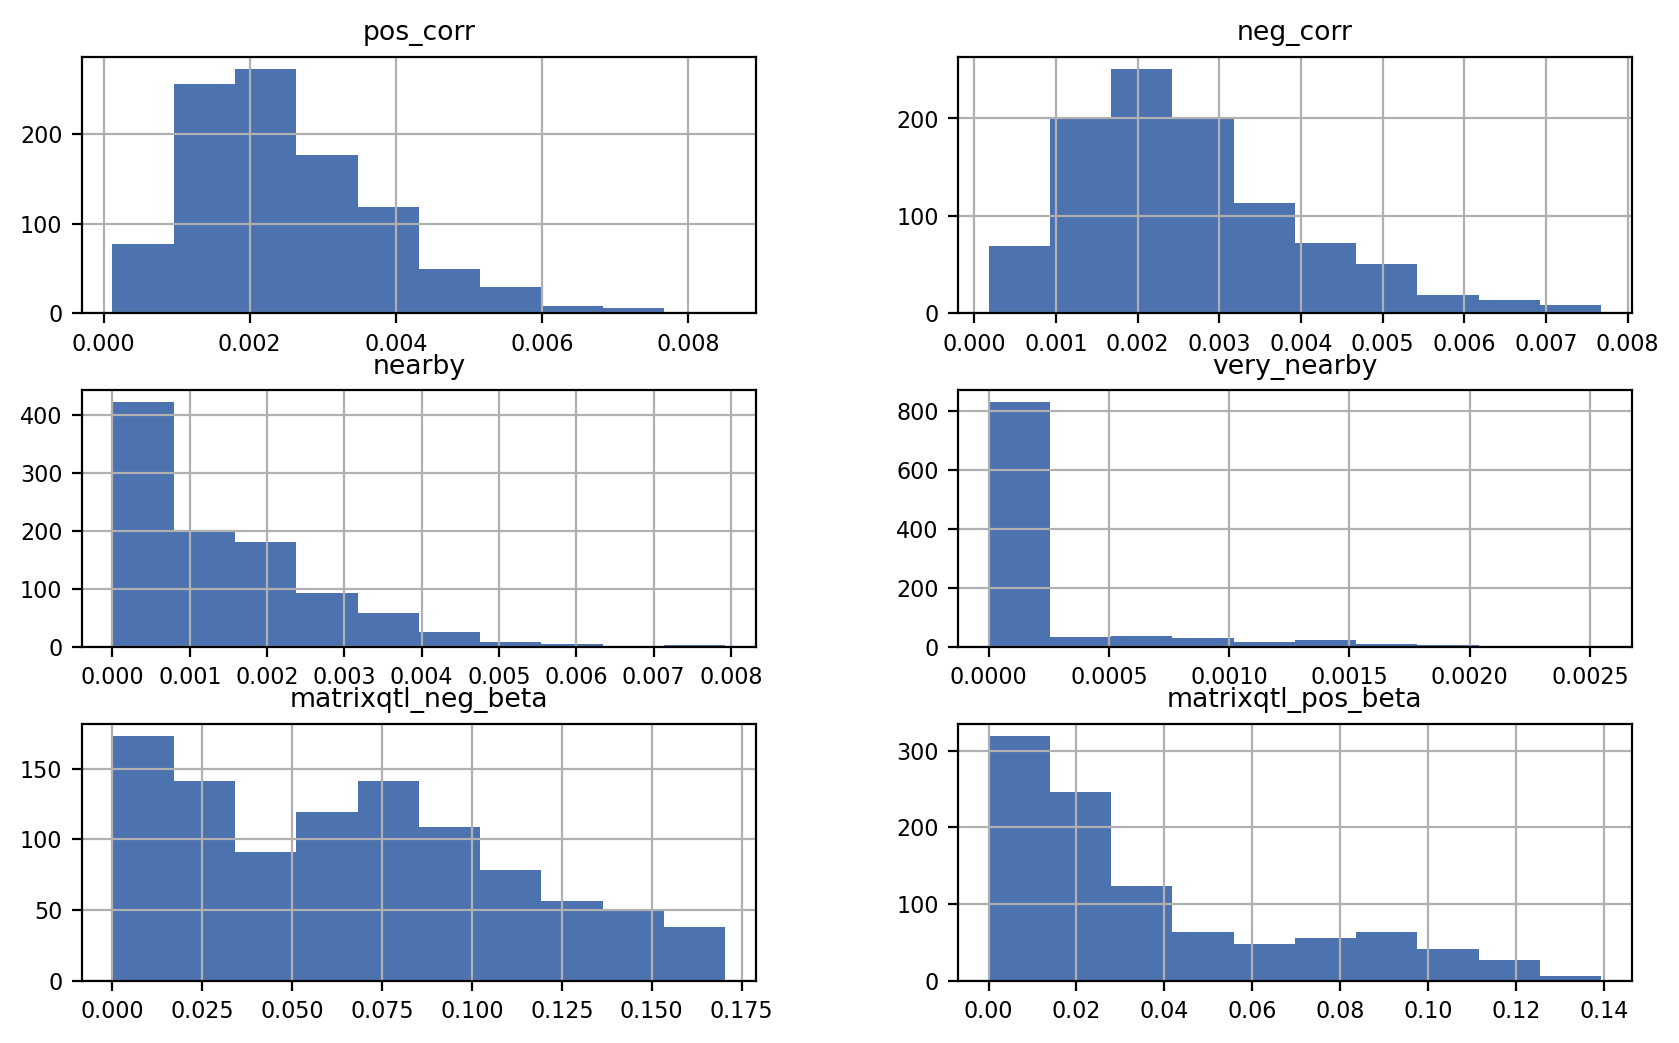

In [73]:
fig, axes = plt.subplots(figsize=(10, 6))
_ = feat_mi_df2.iloc[:6, :].T.hist(ax = axes)

/tmp/ipykernel_1696352/4237579638.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = feat_mi_df1.iloc[:6, :].T.hist(ax = axes)


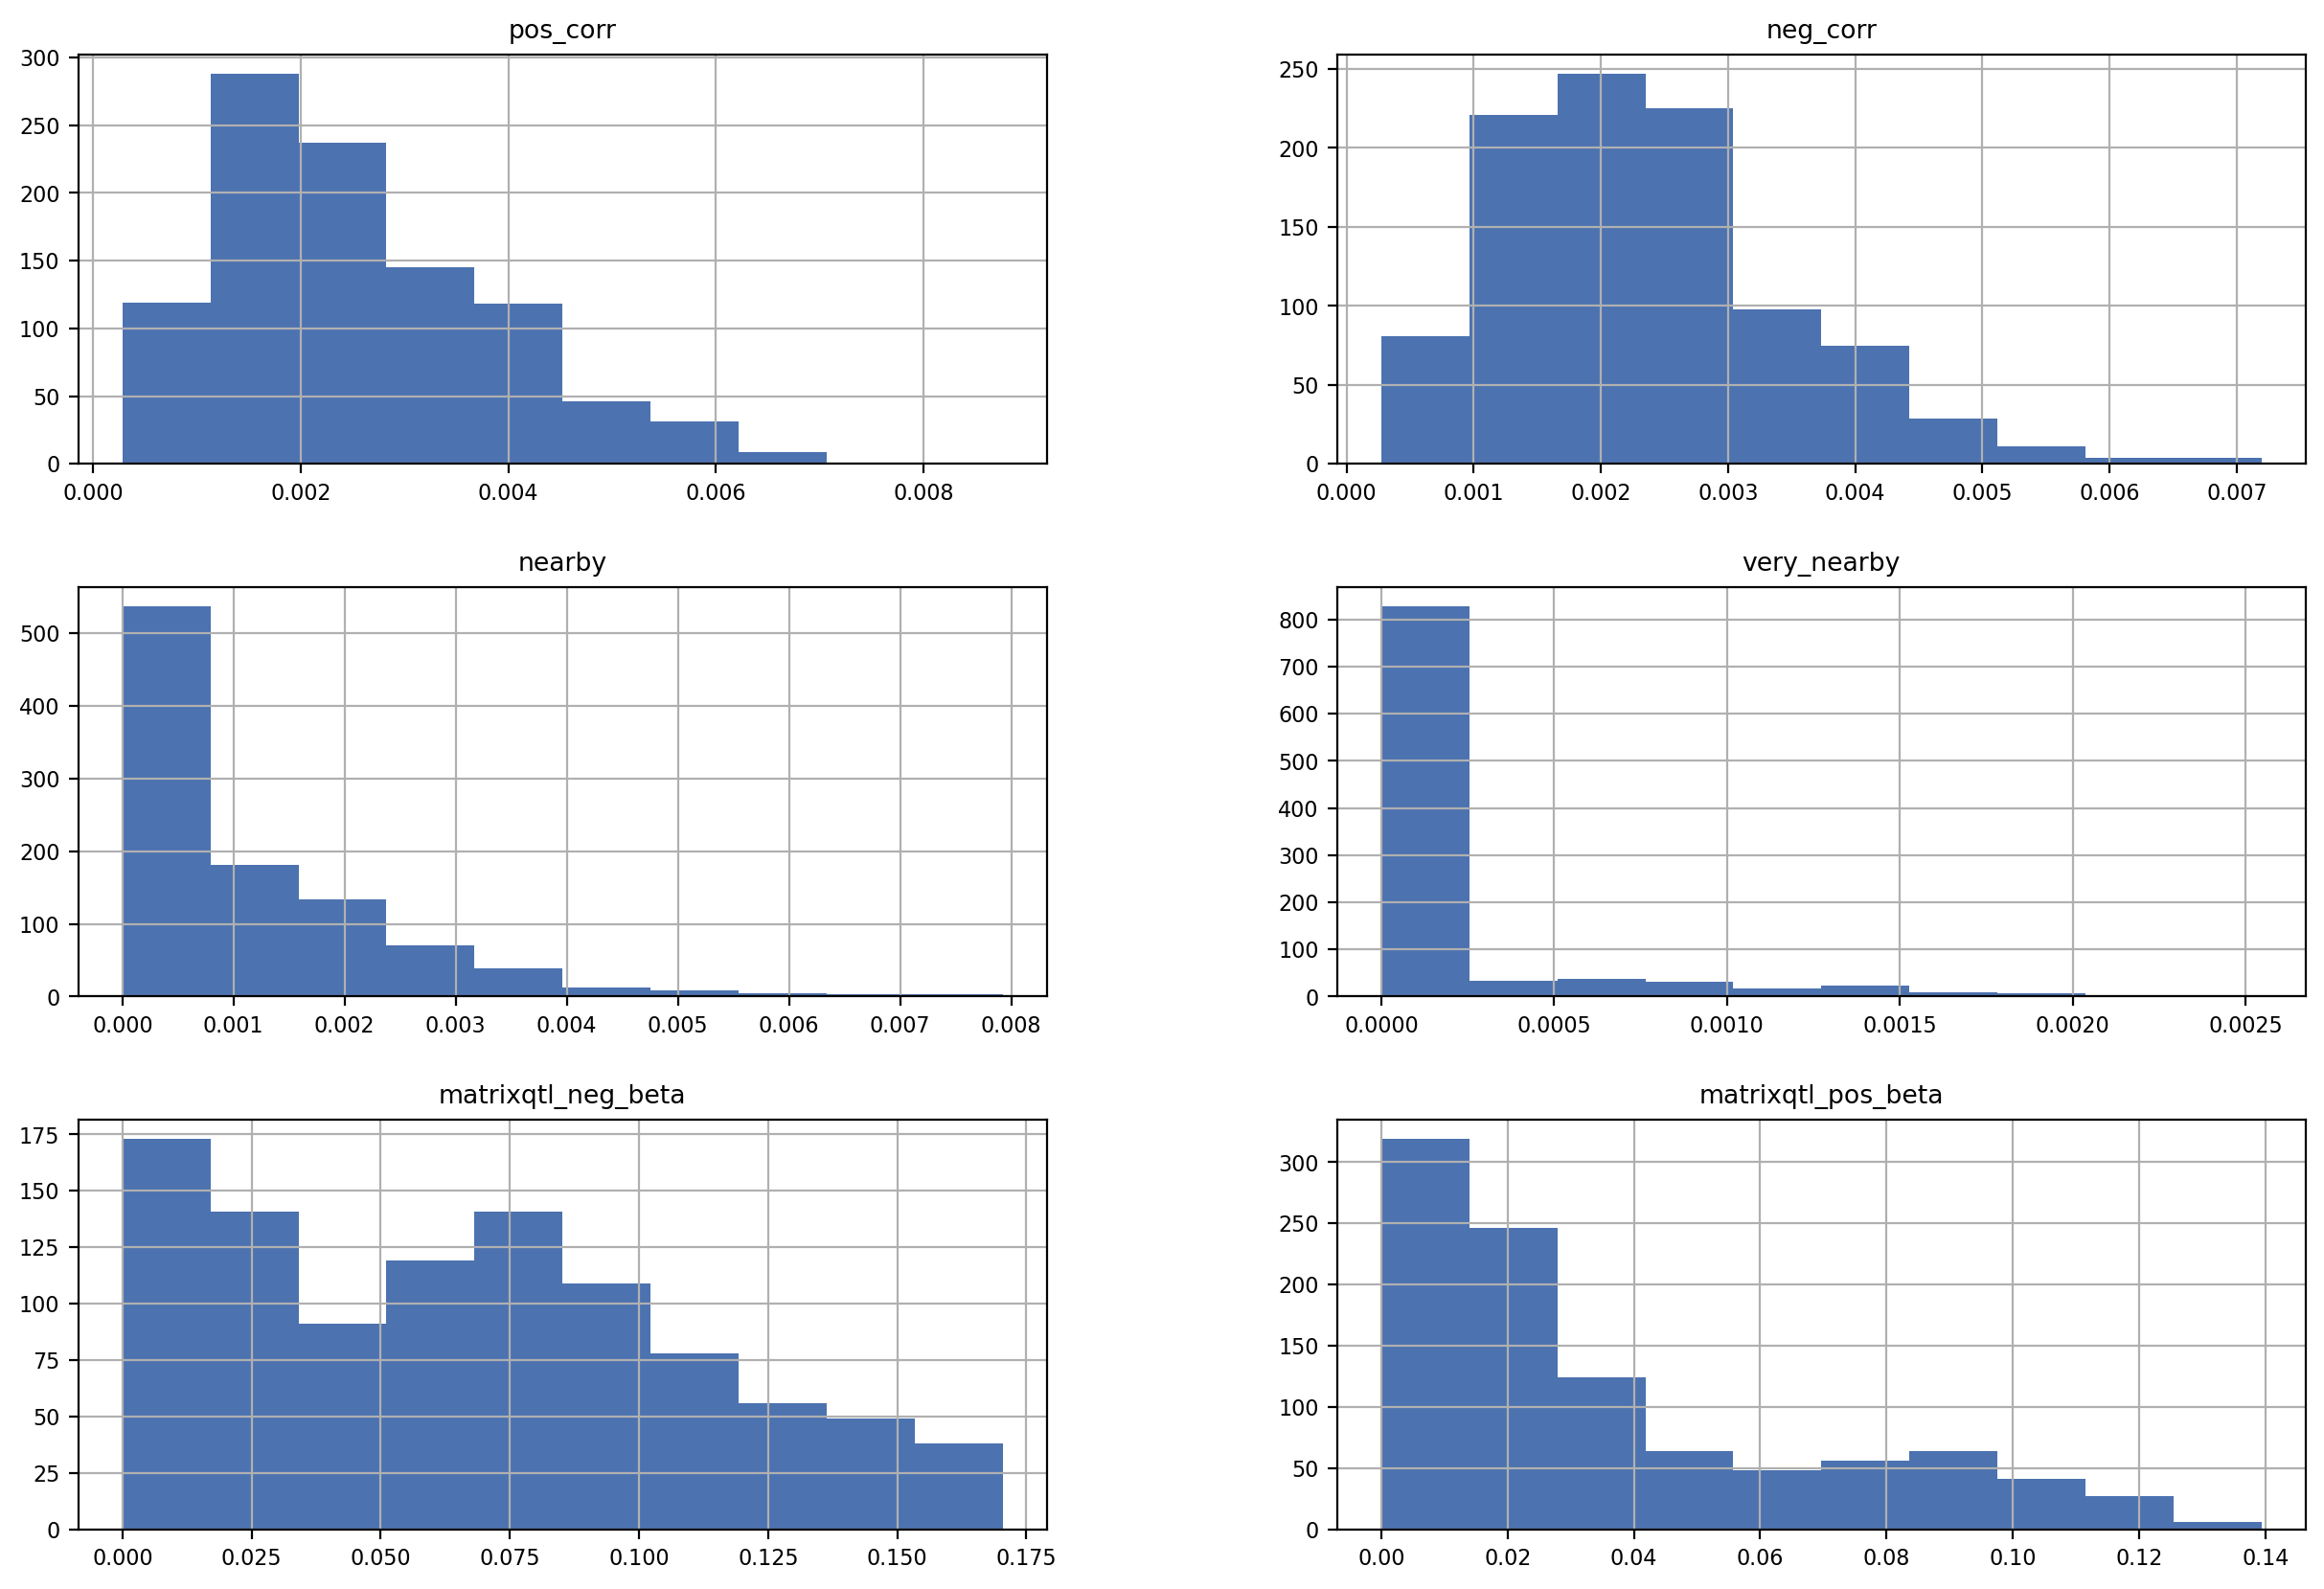

In [74]:
fig, axes = plt.subplots(figsize=(15, 10))
_ = feat_mi_df1.iloc[:6, :].T.hist(ax = axes)

/tmp/ipykernel_1696352/2834338713.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  _ = feat_mi_df3.iloc[:6, :].T.hist(ax = axes)


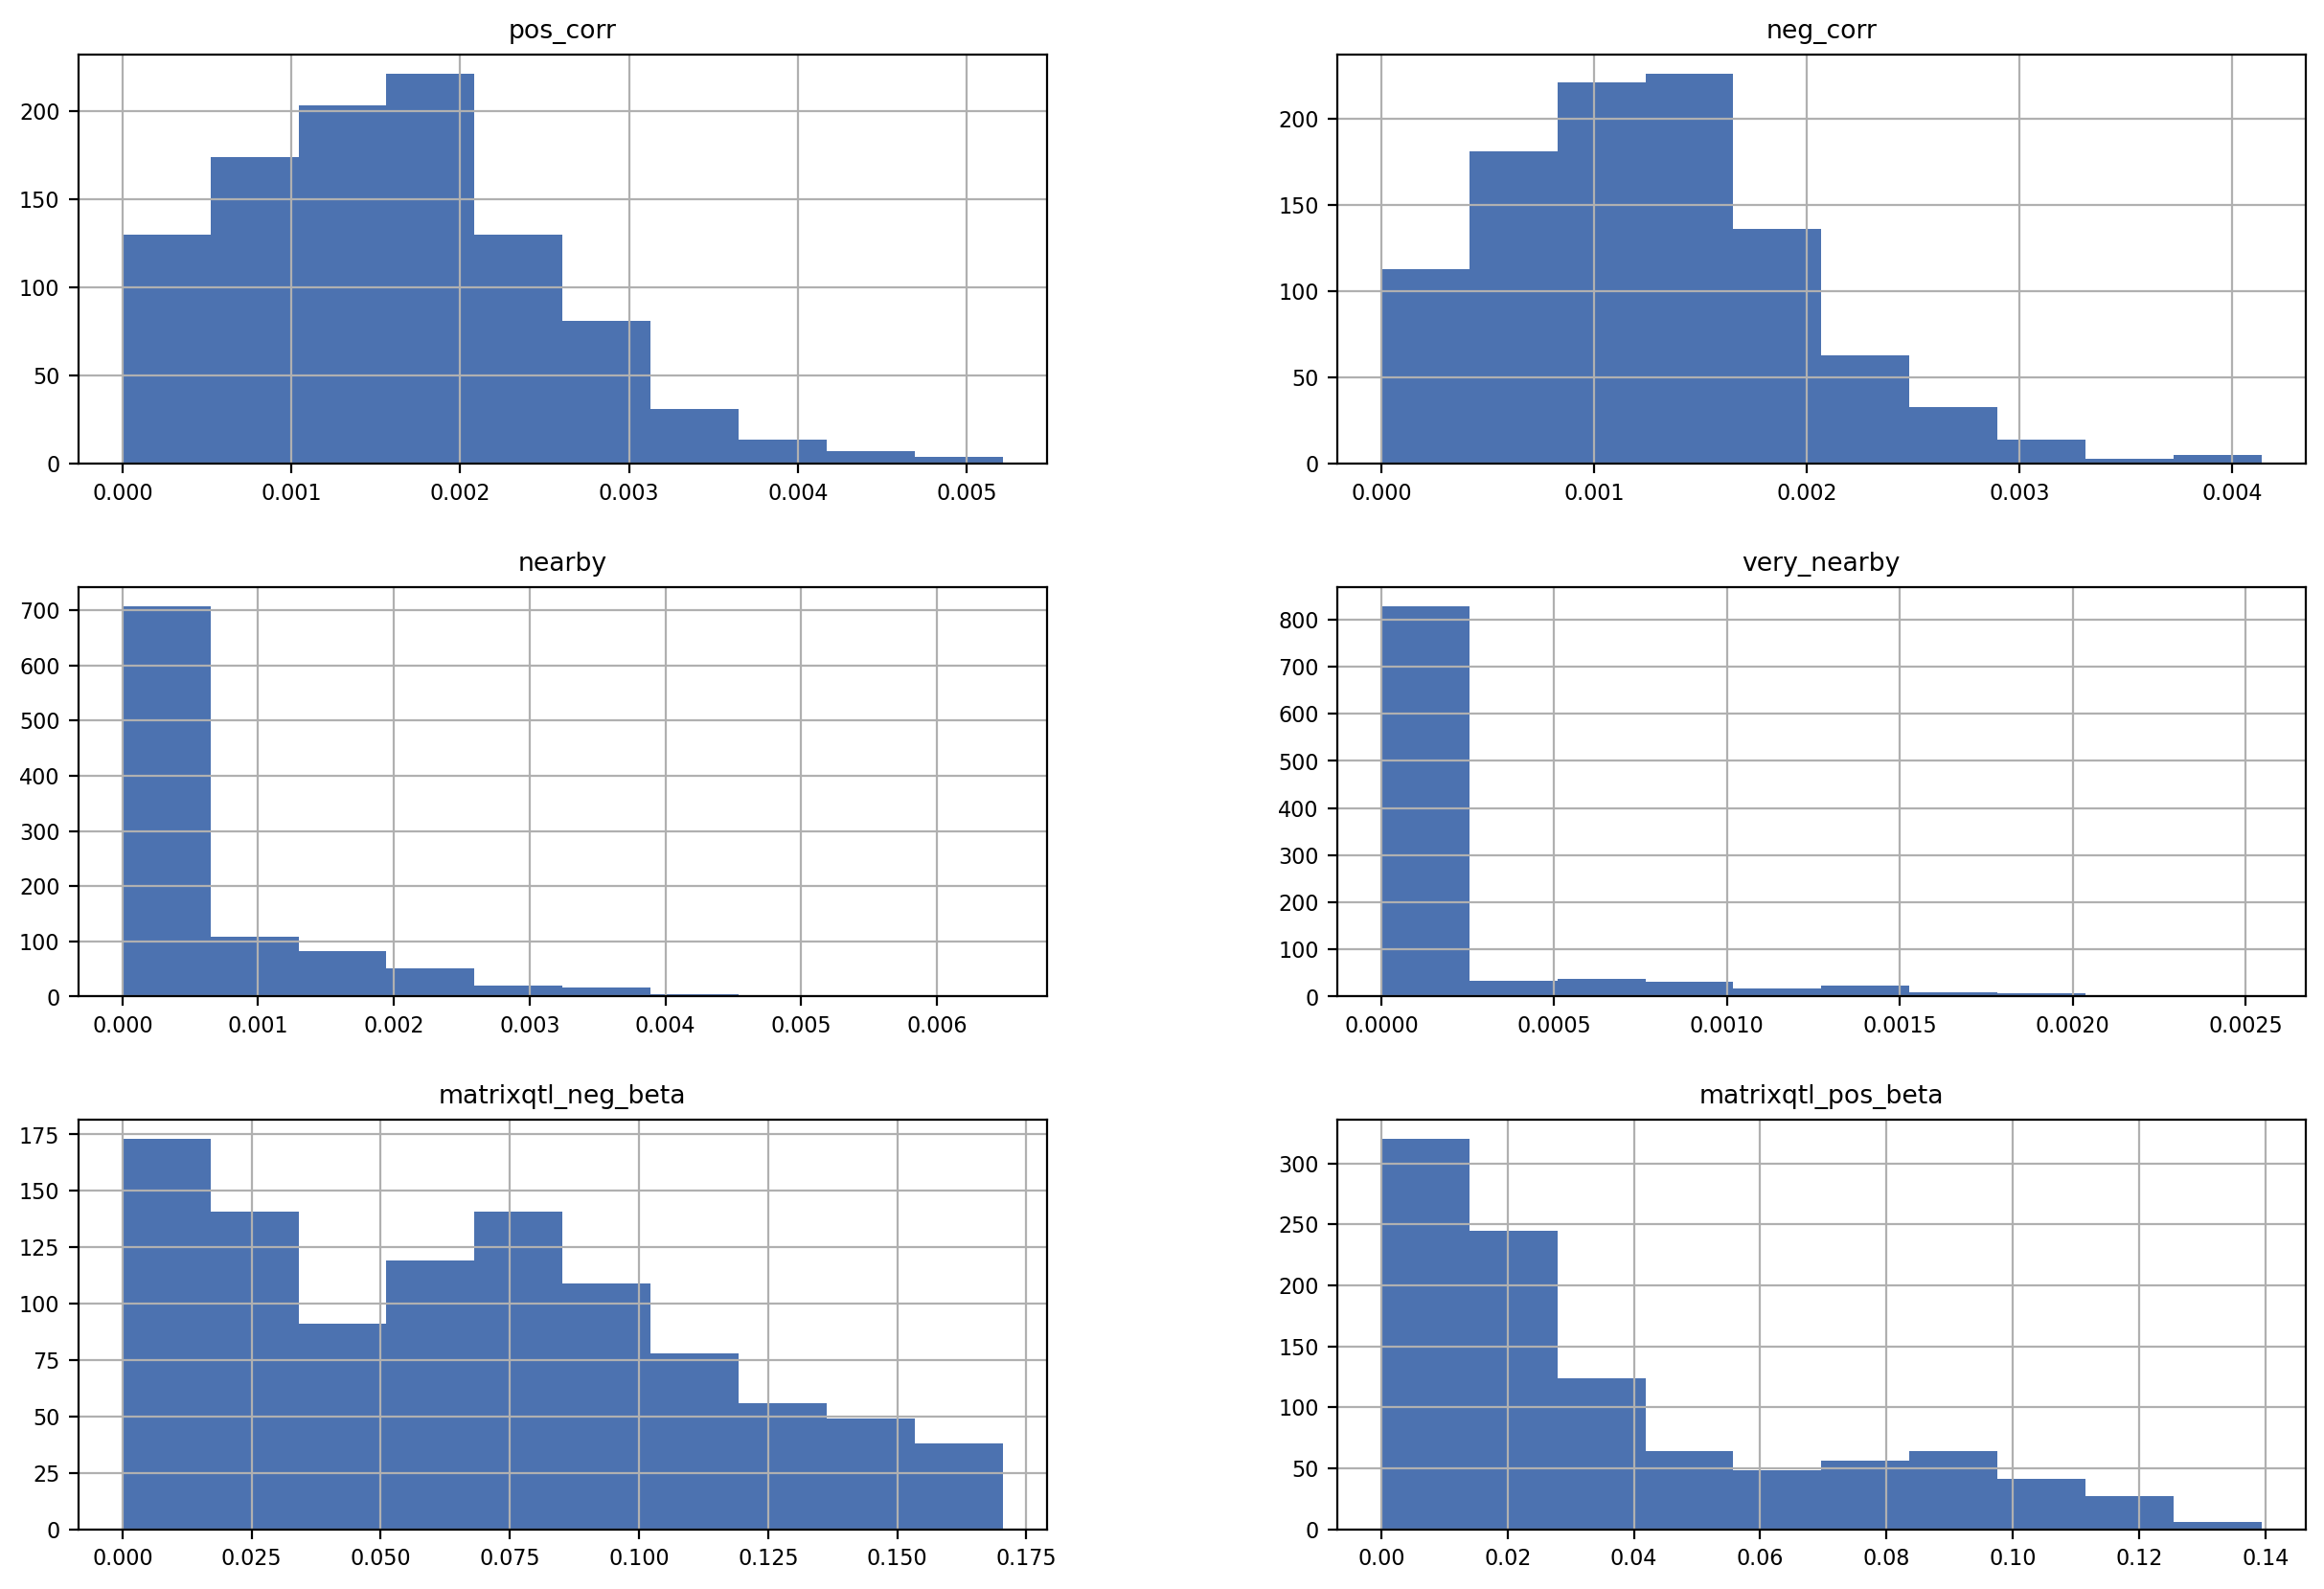

In [75]:
fig, axes = plt.subplots(figsize=(15, 10))
_ = feat_mi_df3.iloc[:6, :].T.hist(ax = axes)

In [67]:
feat_mi_df2.iloc[:6, :].sum(axis=0).sort_values(ascending=False)

cg18578096    0.192378
cg24302412    0.191210
cg05812266    0.186505
cg25011252    0.185699
cg18693673    0.185594
                ...   
cg09895822    0.003786
cg00343092    0.003215
cg04549287    0.003078
cg01580655    0.002923
cg03935352    0.002604
Length: 995, dtype: float64

In [ ]:
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/5000correl_5000meqtl_5000window_80percTrain"
feat_mi_noAgg_df1 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 5000,
        max_meqtl_sites = 5000, nearby_window_size = 5000, aggregate = False,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )

feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/10000correl_10000meqtl_10000window_80percTrain"
feat_mi_noAgg_df2 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 10000,
        max_meqtl_sites = 10000, nearby_window_size = 10000, aggregate = False,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )

feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/1000correl_1000meqtl_1000window_80percTrain"
feat_mi_noAgg_df3 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 1000, aggregate = False,
        do = 'mutual_info', cpg_ids = mi_df.index[:1000].to_list(), feat_store = feat_store
        )

In [80]:
# Compare mutual info distributions without aggregation
mi_sum_2 = feat_mi_noAgg_df2.loc[~(feat_mi_noAgg_df2.index.str.startswith('dataset_')) & ~(feat_mi_noAgg_df2.index.str.startswith('gender_')), :].sum(axis=0)
mi_sum_1 = feat_mi_noAgg_df1.loc[~(feat_mi_noAgg_df1.index.str.startswith('dataset_')) & ~(feat_mi_noAgg_df1.index.str.startswith('gender_')), :].sum(axis=0)
mi_sum_3 = feat_mi_noAgg_df3.loc[~(feat_mi_noAgg_df3.index.str.startswith('dataset_')) & ~(feat_mi_noAgg_df3.index.str.startswith('gender_')), :].sum(axis=0)
# create a dataframe with the mutual info sums as columns
mi_sum_df = pd.DataFrame([mi_sum_1, mi_sum_2, mi_sum_3]).T

In [ ]:
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/5000correl_5000meqtl_5000window_80percTrain"
eval_df1 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 5000,
        max_meqtl_sites = 5000, nearby_window_size = 5000, aggregate = True,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/10000correl_10000meqtl_10000window_80percTrain"
eval_df2 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 10000,
        max_meqtl_sites = 10000, nearby_window_size = 10000, aggregate = True,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/1000correl_1000meqtl_1000window_80percTrain"
eval_df3 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 1000, aggregate = True,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )

In [93]:
eval_df3['diff_r2'] = eval_df3['r2'] - eval_df3['base_r2']
eval_df3['diff_mae'] = eval_df3['mae'] - eval_df3['base_mae']

In [94]:
eval_df3['diff_r2'].max()

0.050607801604538316

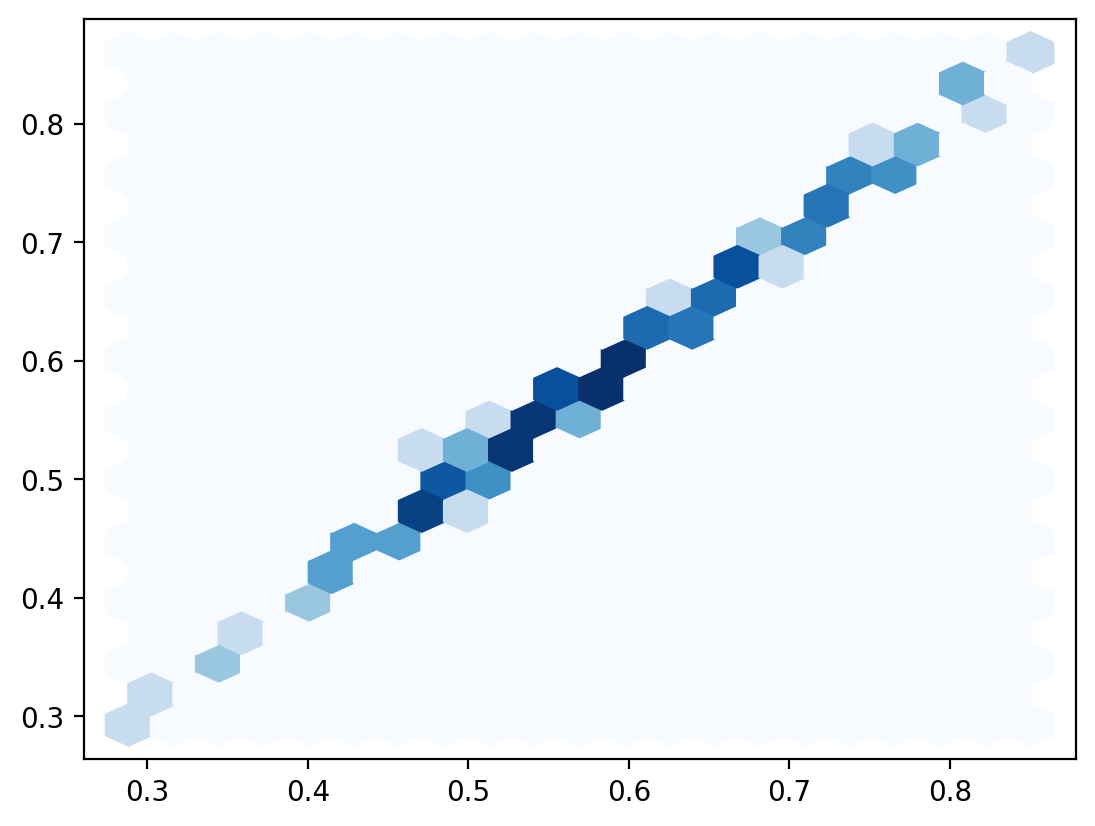

In [88]:
plt.hexbin(eval_df2['base_r2'], eval_df2['r2'], gridsize=20, cmap='Blues', bins = 'log')

In [ ]:
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/5000correl_5000meqtl_5000window_80percTrain"
eval_noAgg_df1 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 5000,
        max_meqtl_sites = 5000, nearby_window_size = 5000, aggregate = False,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/10000correl_10000meqtl_10000window_80percTrain"
eval_noAgg_df2 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 10000,
        max_meqtl_sites = 10000, nearby_window_size = 10000, aggregate = False,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )
feat_store = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011123_output/1000correl_1000meqtl_1000window_80percTrain"
eval_noAgg_df3 = mut_clock.train_all_predictors(
        train_samples = training_samples, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 1000, aggregate = False,
        do = 'evaluate', cpg_ids = mi_df.index[:200].to_list(), feat_store = feat_store
        )

In [28]:
eval_noAgg_df2['diff_r2'] = eval_noAgg_df2['r2'] - eval_noAgg_df2['base_r2']
eval_noAgg_df2['diff_mae'] = eval_noAgg_df2['mae'] - eval_noAgg_df2['base_mae']

In [90]:
eval_noAgg_df2['diff_mae'].max()

0.000294092416912195

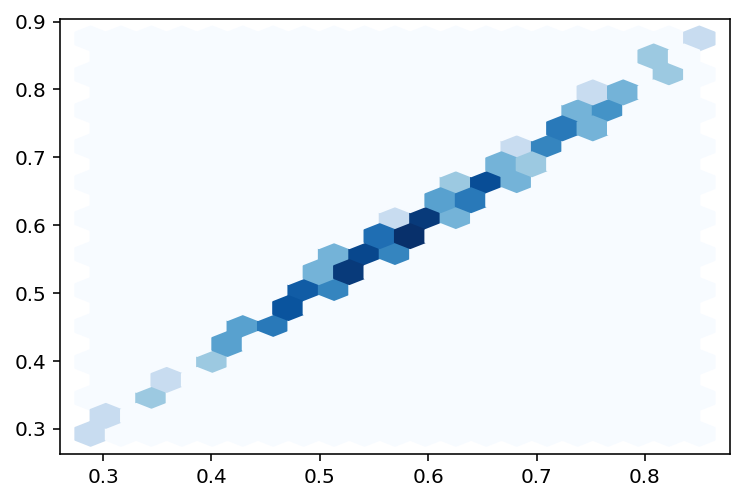

In [32]:
plt.hexbin(eval_noAgg_df2['base_r2'], eval_noAgg_df2['r2'], gridsize=20, cmap='Blues', bins = 'log')

#### Train epi clock

In [19]:
#all_pred_methyl_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top10000mi.parquet")
all_pred_methyl_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi.parquet")

In [21]:
# save as dask dataframe
all_pred_methyl_dd = dd.from_pandas(all_pred_methyl_df, npartitions=100)
# save all_pred_methyl_dd to parquet
all_pred_methyl_dd.to_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi_dask.parquet")

In [26]:
test_df = mut_clock.all_methyl_age_df_t.loc[testing_samples, :]
ages = test_df['age_at_index']
test_df = test_df.iloc[:, 1:-36]
results_df = mut_clock.train_epi_clock(
    X = test_df,
    y = ages, 
    out_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423",
    cpg_ids = all_pred_methyl_df.columns.to_list()
    )

[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=48)]: Done   5 out of   5 | elapsed:  7.2min finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
.........................................................................................................................................................................................................................................................................

In [48]:
results_df.to_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_actual_methyl_top170000mi_epi_clock_results.csv")

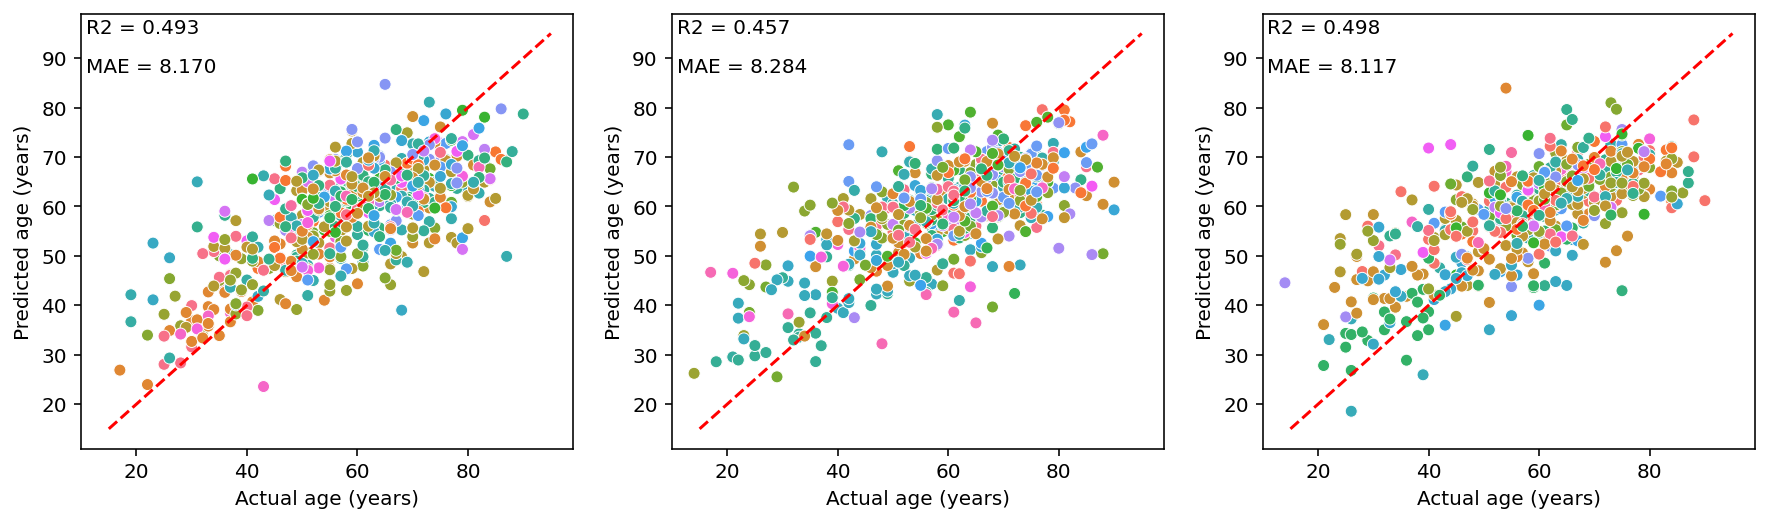

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for i in range(3):
    to_plot = results_df.loc[i, 'tests'].to_frame().join(mut_clock.all_methyl_age_df_t.loc[:, 'dataset'])
    to_plot['preds'] = results_df.loc[i, 'preds']
    to_plot.columns = ['Actual age (years)', 'Dataset', 'Predicted age']
    sns.scatterplot(data=to_plot, x='Actual age (years)', y='Predicted age', hue='Dataset', ax=axes[i], legend=False)
    # axes[i].scatter(results_df.loc[i, 'tests'], results_df.loc[i, 'preds'], s=4, c=)
    # plot the identity line
    axes[i].plot([15, 95], [15, 95], color='red', linestyle='--')
    axes[i].set_xlabel('Actual age (years)')
    axes[i].set_ylabel('Predicted age (years)')
    # write r2 and mae in upper left corner
    axes[i].text(.01, .99, f"R2 = {results_df.loc[i, 'r2']:.3f}", ha='left', va='top',  transform=axes[i].transAxes )
    axes[i].text(.01, .9, f"MAE = {results_df.loc[i, 'mae']:.3f}", ha='left', va='top',  transform=axes[i].transAxes)

In [38]:
pred_results_df = mut_clock.train_epi_clock(
    X = all_pred_methyl_df,
    y = ages, 
    out_fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423",
    cpg_ids = all_pred_methyl_df.columns
    )

[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=48)]: Done   5 out of   5 | elapsed: 17.9min finished
[Parallel(n_jobs=48)]: Using backend ThreadingBackend with 48 concurrent workers.
.........................................................................................................................................................................................................................................................................

In [44]:
pred_results_df

,r2,mae,preds,tests
0,0.259475,10.090537,"[49.268368320565685, 72.91301899637352, 63.058...",sample TCGA-C5-A907 47 TCGA-N5-A4RJ 61 T...
1,0.253878,9.846506,"[60.14921013790499, 48.97917881323774, 66.2704...",sample TCGA-CQ-A4CH 58 TCGA-AB-2964 58 T...
2,0.260574,10.063094,"[60.44416003653516, 59.28006094391417, 60.9338...",sample TCGA-DX-A3U6 63 TCGA-OL-A5RU 63 T...


In [47]:
pred_results_df.to_csv("/cellar/users/zkoch/methylation_and_mutation/output_dirs/output_010423/testing_predicted_methyl_top170000mi_clock_results.csv")

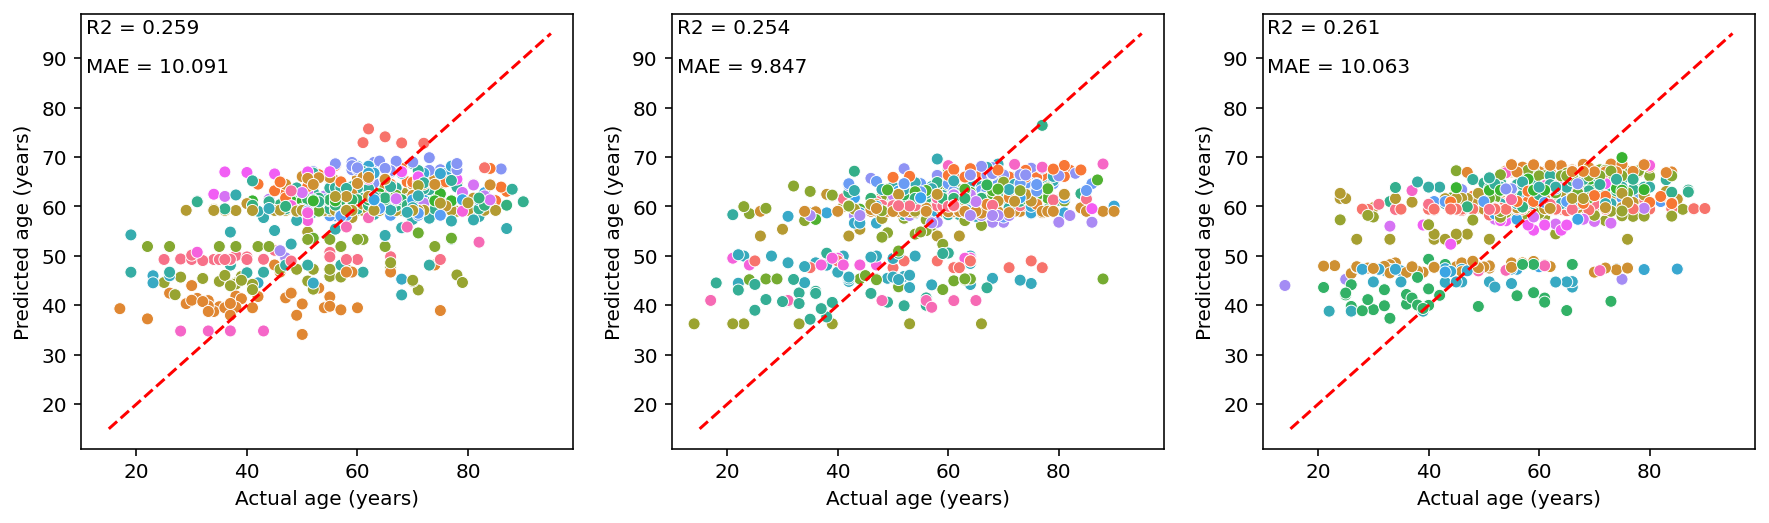

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
for i in range(3):
    to_plot = pred_results_df.loc[i, 'tests'].to_frame().join(mut_clock.all_methyl_age_df_t.loc[:, 'dataset'])
    to_plot['preds'] = pred_results_df.loc[i, 'preds']
    to_plot.columns = ['Actual age (years)', 'Dataset', 'Predicted age']
    sns.scatterplot(data=to_plot, x='Actual age (years)', y='Predicted age', hue='Dataset', ax=axes[i], legend=False)    # plot the identity line
    axes[i].plot([15, 95], [15, 95], color='red', linestyle='--')
    axes[i].set_xlabel('Actual age (years)')
    axes[i].set_ylabel('Predicted age (years)')
    # write r2 and mae in upper left corner
    axes[i].text(.01, .99, f"R2 = {pred_results_df.loc[i, 'r2']:.3f}", ha='left', va='top',  transform=axes[i].transAxes )
    axes[i].text(.01, .9, f"MAE = {pred_results_df.loc[i, 'mae']:.3f}", ha='left', va='top',  transform=axes[i].transAxes)
    

# ICGC

#### ICGC Preprocessing

In [ ]:
# read in mutations
icgc_mut = pd.read_csv(os.path.join(icgc_dir, "simple_somatic_mutation.open.tsv.gz"))
# drop rows that are not a string value
icgc_mut_str = icgc_mut[icgc_mut["submitted_matched_sample_id"].apply(lambda x: isinstance(x, str))]
# get rows of icgc_mut where submitted_sample_id starts with tcga or not
tcga_icgc_mut = icgc_mut_str.loc[icgc_mut_str['submitted_sample_id'].str.startswith('TCGA', na=False)]
not_tcga_icgc_mut = icgc_mut_str.loc[~icgc_mut_str['submitted_sample_id'].str.startswith('TCGA', na=False)]
# convert to tcga format
tcga_ids = tcga_icgc_mut['submitted_sample_id'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1] + '-' + x.split('-')[2])
# get the intersection of tcga_ids and all_mut_w_age_df['case_submitter_id'].unique()
duplicate = tcga_ids[tcga_ids.isin(all_mut_w_age_df['case_submitter_id'].unique())]
new = tcga_ids[~tcga_ids.isin(all_mut_w_age_df['case_submitter_id'].unique())]
# get dataframe of the new mutations (TCGA but not in all_mut_w_age_df or not tcga at all)
new_non_tcga_samples = not_tcga_icgc_mut['submitted_sample_id'].unique()
new_icgc_mut_df = icgc_mut_str.loc[(icgc_mut_str['submitted_sample_id'].isin(new)) | (icgc_mut_str['submitted_sample_id'].isin(new_non_tcga_samples)), :]
# keep only columns we care about 
new_icgc_mut_df = new_icgc_mut_df[['icgc_donor_id','icgc_sample_id','submitted_sample_id', 'chromosome', 'chromosome_start', 'mutation_type','mutated_from_allele','mutated_to_allele','total_read_count', 'mutant_allele_read_count']]
new_icgc_mut_df.reset_index(inplace=True, drop=True)
new_icgc_mut_df['MAF'] = new_icgc_mut_df['mutant_allele_read_count'] / new_icgc_mut_df['total_read_count']
new_icgc_mut_df['submitted_sample_id'] = new_icgc_mut_df['submitted_sample_id'].astype(str)
new_icgc_mut_df.drop_duplicates(inplace=True)
new_icgc_mut_df.to_parquet(os.path.join(icgc_dir, "all_mut_no_TCGAdups.parquet"))

# read in metadata 
icgc_meta_df = pd.read_csv(os.path.join(icgc_dir, "donor.tsv.gz"), sep='\t')
icgc_meta_df = icgc_meta_df[['icgc_donor_id', 'project_code','submitted_donor_id', 'donor_sex','donor_age_at_diagnosis']]
icgc_meta_df.to_parquet(os.path.join(icgc_dir, "icgc_meta_df.parquet"))

In [ ]:
# read meta, mut, and methyl
icgc_meta_df = pd.read_parquet(os.path.join(icgc_dir, "icgc_meta_df.parquet"))
icgc_mut_df = pd.read_parquet(os.path.join(icgc_dir, "all_mut_no_TCGAdups.parquet"))
icgc_methyl_df = dd.read_parquet(os.path.join(icgc_dir, "methyl_dir"))
icgc_methyl_df = icgc_methyl_df.compute()
icgc_methyl_df_t = icgc_methyl_df.T

# how many sample do we have mutation, age, and methylation for?
mut_samples = icgc_mut_df['icgc_donor_id'].unique()
meta_samples = icgc_meta_df['icgc_donor_id'].unique()
methyl_samples = icgc_methyl_df_t.index.values
# intersection 
mut_meta_samples = np.intersect1d(mut_samples, meta_samples)
mut_meta_methyl_samples = np.intersect1d(mut_meta_samples, methyl_samples)
icgc_methyl_df_t = icgc_methyl_df.loc[mut_meta_methyl_samples, :]
icgc_meta_df = icgc_meta_df.loc[icgc_meta_df['icgc_donor_id'].isin(mut_meta_methyl_samples), :]
icgc_methyl_df_t.dropna(how='any', axis = 1, inplace=True)

icgc_mut_df.dropna(how='any', inplace=True, subset=['MAF', 'sample', 'mut_loc'])
# rename to make match tcga data
icgc_mut_df.rename(columns={'icgc_donor_id':'sample', 'mut_event': 'mut_loc'}, inplace=True)
icgc_mut_df.reset_index(inplace=True, drop=True)
icgc_meta_df.rename(columns={'icgc_donor_id': 'sample', 'project_code': 'dataset', 'donor_sex': 'gender', 'donor_age_at_diagnosis': 'age_at_index'}, inplace=True)


In [ ]:
print(f"We have {len(mut_samples)} with mutations, {len(meta_samples)} with meta, and {len(methyl_samples)} with methylation and {len(mut_meta_methyl_samples)} with all three.")

We have 672 with mutations, 2329 with meta, and 2329 with methylation and 672 with all three.


In [ ]:
# write out each file
icgc_meta_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
icgc_methyl_df_t.to_csv("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_methyl_df_cpgXsamples.csv.gz", compression='gzip')
icgc_mut_df.to_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
# convert to dask df 
icgc_methyl_dd_t = dd.from_pandas(icgc_methyl_df_t, npartitions=100)
icgc_methyl_dd_t.to_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_methyl_df_samplesXcpg')

In [4]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
# read in methyl from dask dir
#icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_methyl_df_samplesXcpg')
#icgc_methyl_df = icgc_methyl_dd.compute()
#icgc_methyl_df_t = icgc_methyl_df.T

In [5]:
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T

In [6]:
shared_samples = set(icgc_methyl_df_t.index.values) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples, :]
icgc_methyl_df_t.dropna(how='any', axis = 1, inplace=True)

In [14]:
icgc_methyl_dd_t = dd.from_pandas(icgc_methyl_df_t, npartitions=100)
icgc_methyl_dd_t.to_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_methyl_df_samplesXcpg')

#### Read in data

In [4]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
# read in methyl from dask dir
#icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_methyl_df_samplesXcpg')
#icgc_methyl_df = icgc_methyl_dd.compute()
#icgc_methyl_df_t = icgc_methyl_df.T
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T
shared_samples = set(icgc_methyl_df_t.index) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples]
icgc_methyl_df_t.dropna(how = 'any', axis=1, inplace=True)

In [5]:
icgc_mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/icgc_mi.parquet')
icgc_mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

In [6]:
# rename columns 
icgc_mut_df.rename(columns={'chromosome':'chr', 'sample': 'case_submitter_id', 'chromosome_start':'start', 'MAF': 'DNA_VAF'}, inplace=True)
icgc_meta_df.rename(columns={'sample': 'case_submitter_id'}, inplace=True)
# merge with mut
icgc_mut_w_age_df = icgc_mut_df.merge(icgc_meta_df, on='case_submitter_id', how='left')
# and methyl dfs
icgc_meta_df_to_merge = icgc_meta_df[['case_submitter_id', 'age_at_index', 'dataset', 'gender']]
icgc_meta_df_to_merge.set_index('case_submitter_id', inplace=True)
# make gender column uppercase
icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()
icgc_methyl_age_df_t = icgc_methyl_df_t.merge(icgc_meta_df_to_merge, left_index=True, right_index=True, how='left')

/tmp/ipykernel_2802333/2635062645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()


#### Mut clock

In [7]:
# create a mutationClock object with icgc data
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df = icgc_mut_w_age_df, 
    illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = icgc_methyl_age_df_t,
    output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output"
    )

In [ ]:
result_df = mut_clock.train_all_predictors(
    do = 'evaluate', num_correl_sites = 1000, max_meqtl_sites = 2000,
    nearby_window_size = 1000, cpg_ids = icgc_mi_df.head(1).index.to_list(), 
    aggregate = False, binarize = False, use_all_muts = False
    )

#### model comparison

In [12]:
result1 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_5000_2500_False_False_False.parquet')
result2 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_5000_2500_False_True_False.parquet')
result3 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_5000_2500_True_False_False.parquet')
result4 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_5000_2500_True_True_False.parquet')
result5 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_100000_2500_False_False_False.parquet')
result6 = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/evaluate_results_ICGC_1000_2000_100000_2500_True_False_False.parquet')

In [14]:
result1['r2']

0    [0.8117939894979405, 0.7603232950635656, 0.729...
0    [0.8620598717894554, 0.8138440207574646, 0.810...
0    [0.9209330500407846, 0.8789805582944893, 0.837...
0    [0.9364254463743362, 0.9112030690996464, 0.911...
0    [0.8587798626331643, 0.794969922801986, 0.7493...
                           ...                        
0    [0.7914084545375984, 0.8083915121494507, 0.713...
0    [0.7205274742333598, 0.7141464050393717, 0.651...
0    [0.6873459109981159, 0.7885697434972618, 0.816...
0    [0.6846502217753343, 0.6980304724565496, 0.701...
0    [0.6611411630143066, 0.7311212422945665, 0.710...
Name: r2, Length: 2480, dtype: object

In [17]:
# get mean metrics and difference
for result_df in [result1, result2, result3, result4, result5, result6]:
    result_df['mean_r2'] = result_df['r2'].apply(lambda x: np.mean(x))
    result_df['mean_mae'] = result_df['mae'].apply(lambda x: np.mean(x))
    result_df['base_mean_r2'] = result_df['base_r2'].apply(lambda x: np.mean(x))
    result_df['base_mean_mae'] = result_df['base_mae'].apply(lambda x: np.mean(x))
    result_df['diff_r2'] = result_df['mean_r2'] - result_df['base_mean_r2']
    result_df['diff_mae'] = result_df['mean_mae'] - result_df['base_mean_mae']
    
    

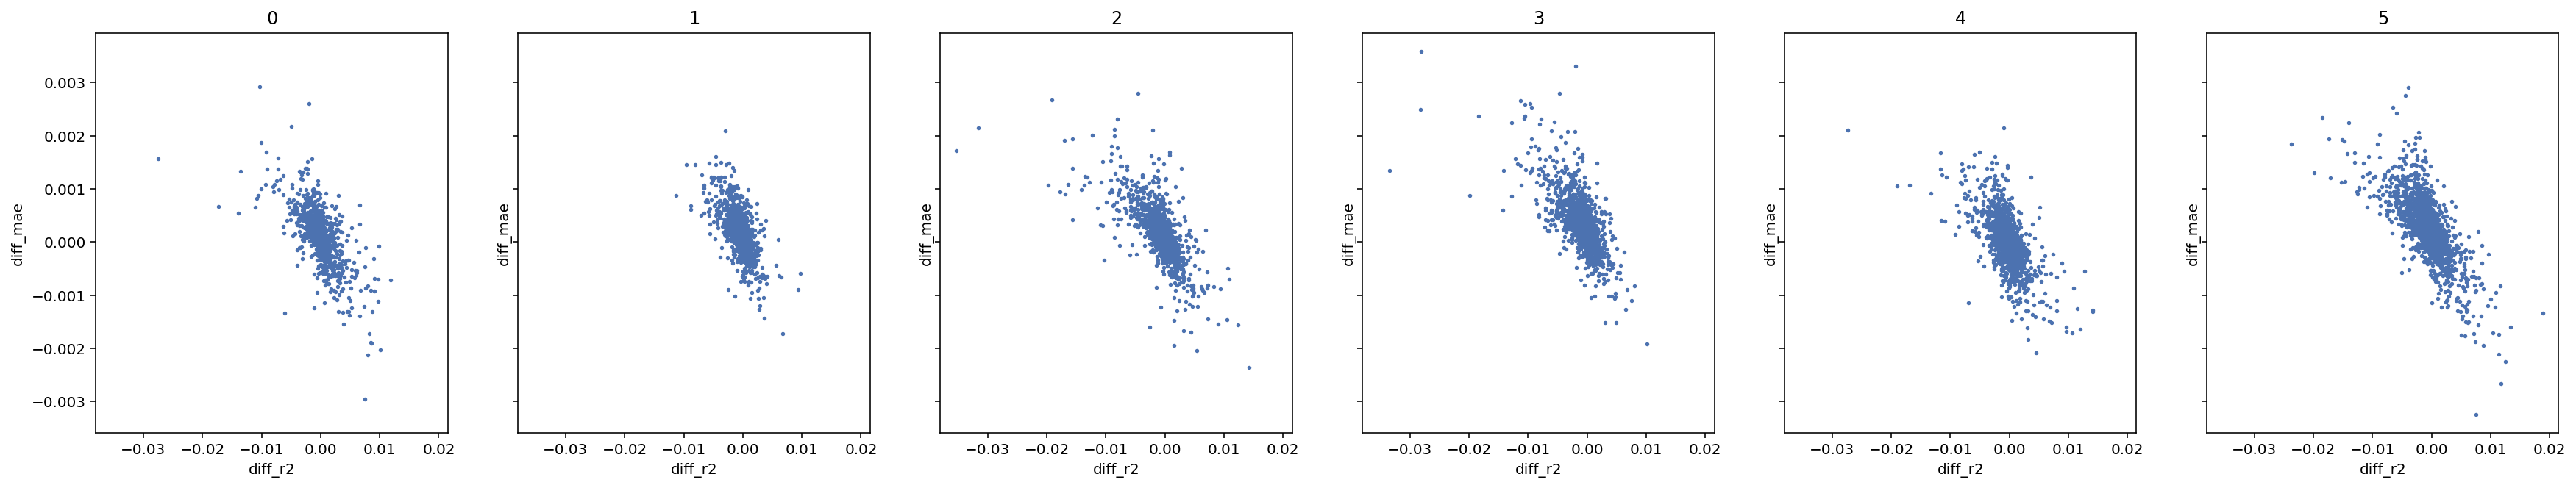

In [23]:
fig, axes = plt.subplots(1, 6, figsize=(30, 5), sharex = True, sharey = True)
# for each result df, plot the diff_r2 vs diff_mae as a scatter plot 
for i, result_df in enumerate([result1, result2, result3, result4, result5, result6]):
    axes[i].scatter(result_df['diff_r2'], result_df['diff_mae'], s=3)
    axes[i].set_title(f"{i}")
    axes[i].set_xlabel('diff_r2')
    axes[i].set_ylabel('diff_mae')
    

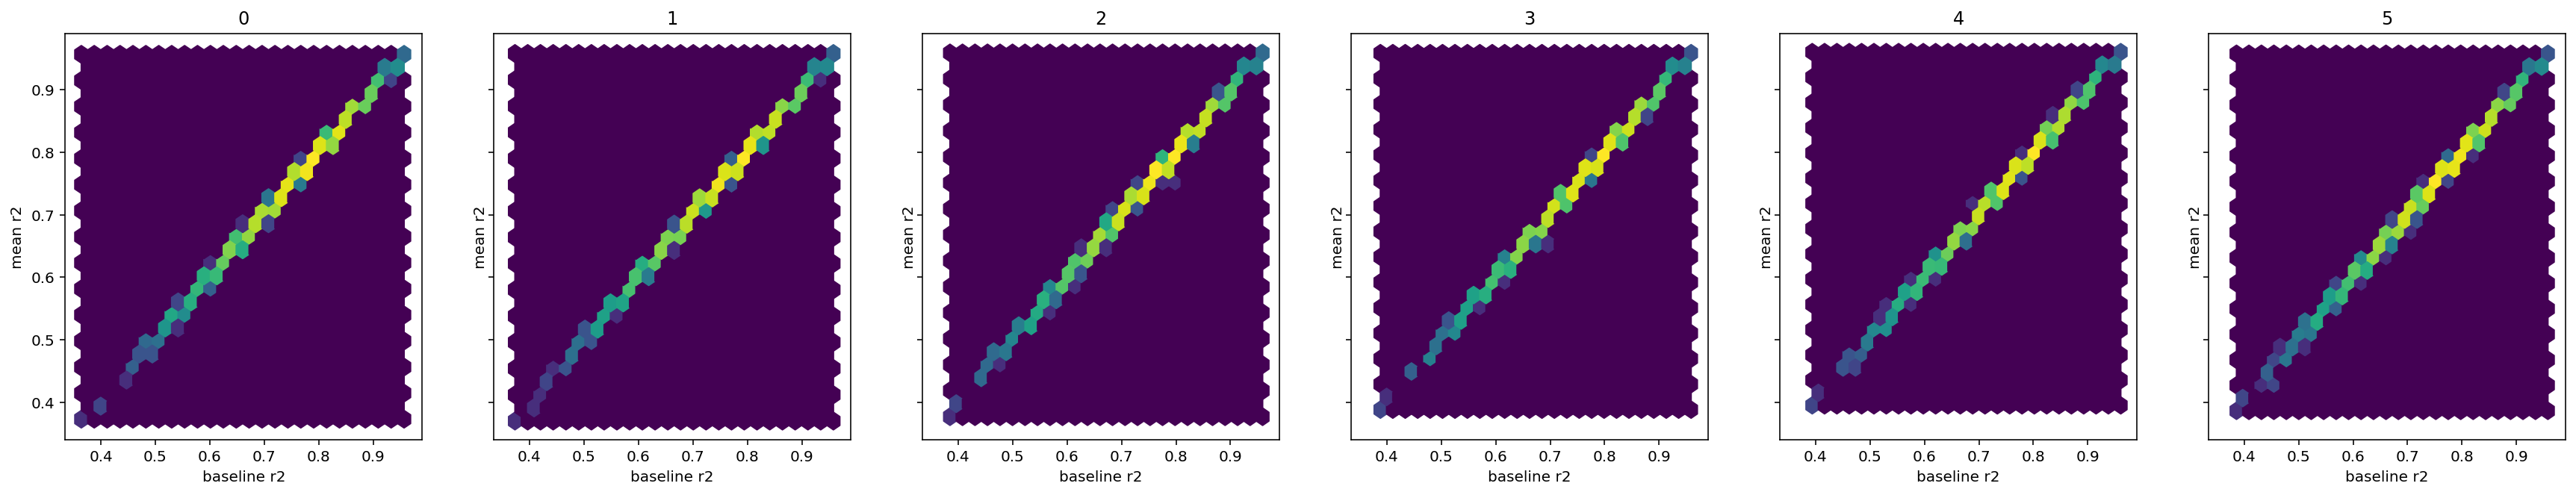

In [27]:
fig, axes = plt.subplots(1, 6, figsize=(30, 5), sharex = True, sharey = True)
# for each result df, plot the diff_r2 vs diff_mae as a scatter plot 
for i, result_df in enumerate([result1, result2, result3, result4, result5, result6]):
    axes[i].hexbin(result_df['base_mean_r2'], result_df['mean_r2'], gridsize=25, bins='log')
    axes[i].set_title(f"{i}")
    axes[i].set_ylabel('mean r2')
    axes[i].set_xlabel('baseline r2')
    